In [1]:
import pandas as pd
import mygene
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import ttest_ind
from gprofiler import GProfiler

c:\Users\david\OneDrive\Desktop\PythonBioinfoAssingment2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1

In [2]:
# Part 1 - Section b
def ensembl_to_symbol(ensembl_ids):
    mg = mygene.MyGeneInfo()
    results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='zebrafish')
    gene_map = {}
    for result in results:
        if 'symbol' in result:
            gene_map[result['query']] = result['symbol']
        else:
            gene_map[result['query']] = result['query']  # Keep original ID if no symbol found
    return gene_map

# Load the TSV file
file_path = 'ERP009868.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

print("Original data shape:", expression_data.shape)
print("First few rows of original data:")
print(expression_data.head())

# Check the format of the index
print("\nFirst few index values:")
print(expression_data.index[:5])

# Convert index (Ensembl IDs) to gene symbols
ensembl_ids = expression_data.index.tolist()
gene_symbols = ensembl_to_symbol(ensembl_ids)

# Print some debug information
print("\nNumber of Ensembl IDs:", len(ensembl_ids))
print("Number of gene symbols mapped:", len([name for name in gene_symbols.values() if name != '']))
print("First few gene symbol mappings:")
for ensembl, symbol in list(gene_symbols.items())[:5]:
    print(f"{ensembl} -> {symbol}")

# Replace Ensembl IDs with gene symbols in the index
expression_data.index = [gene_symbols.get(id, id) for id in expression_data.index]

# Print intermediate result
print("\nAfter gene symbol mapping:")
print(expression_data.head())

# If there are duplicate gene symbols, aggregate them by taking the mean
expression_data = expression_data.groupby(expression_data.index).mean()

print("\nFinal converted data shape:", expression_data.shape)
print("First few rows of converted data:")
print(expression_data.head())

# Save the converted data to a new TSV file
output_file = 'ERP009868_symbols.tsv'
expression_data.to_csv(output_file, sep='\t')
print(f"\nConverted data saved to {output_file}")

Original data shape: (31882, 1886)
First few rows of original data:
                     ERR1046065   ERR1046066   ERR1046067   ERR1046068  \
Gene                                                                     
ENSDARG00000000001     0.000000     1.882786     0.970794     0.000000   
ENSDARG00000000002   108.934780   171.447810   153.786990   153.121580   
ENSDARG00000000018   151.847600   118.113464   133.184840   191.133770   
ENSDARG00000000019  2552.638200  1639.096300  1813.370100  1666.400300   
ENSDARG00000000068     3.655305     4.331904     3.624755     6.494877   

                     ERR1046069   ERR1046070   ERR1046071   ERR1046072  \
Gene                                                                     
ENSDARG00000000001     0.984327     0.000000     0.000000     0.967930   
ENSDARG00000000002   153.099240    76.990480   216.064210   206.836320   
ENSDARG00000000018   132.907530   154.294390   179.296080   224.272670   
ENSDARG00000000019  1432.987900  1029.32500

63 input query terms found dup hits:	[('ENSDARG00000003244', 2), ('ENSDARG00000009673', 2), ('ENSDARG00000039752', 2), ('ENSDARG000000416
116 input query terms found no hit:	['ENSDARG00000019591', 'ENSDARG00000036501', 'ENSDARG00000037589', 'ENSDARG00000044622', 'ENSDARG000



Number of Ensembl IDs: 31882
Number of gene symbols mapped: 31882
First few gene symbol mappings:
ENSDARG00000000001 -> slc35a5
ENSDARG00000000002 -> ccdc80
ENSDARG00000000018 -> nrf1
ENSDARG00000000019 -> ube2h
ENSDARG00000000068 -> nherf1a

After gene symbol mapping:
          ERR1046065   ERR1046066   ERR1046067   ERR1046068   ERR1046069  \
slc35a5     0.000000     1.882786     0.970794     0.000000     0.984327   
ccdc80    108.934780   171.447810   153.786990   153.121580   153.099240   
nrf1      151.847600   118.113464   133.184840   191.133770   132.907530   
ube2h    2552.638200  1639.096300  1813.370100  1666.400300  1432.987900   
nherf1a     3.655305     4.331904     3.624755     6.494877     5.328189   

          ERR1046070   ERR1046071   ERR1046072   ERR1046073  ERR1046074  ...  \
slc35a5     0.000000     0.000000     0.967930     0.000000         0.0  ...   
ccdc80     76.990480   216.064210   206.836320    96.608505         0.0  ...   
nrf1      154.294390   179.29608

In [3]:
# Part 1 - Section c
# Load the processed data
file_path = 'ERP009868_symbols.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

# Find the size of the matrix
print("Data shape (samples x genes):", expression_data.shape)

# Find the number of genes
num_genes = expression_data.shape[0]  # Rows represent genes
print(f"Number of genes: {num_genes}")

# Log-scale the data (adding 1 to avoid log(0))
log_expression_data = np.log2(expression_data + 1)
print("Log-scaled data:")
print(log_expression_data.head())

# Calculate per-gene median expression
median_expression = log_expression_data.median(axis=1)  # Row-wise median (per gene)
print("First few per-gene median values:")
print(median_expression.head())


Data shape (samples x genes): (29346, 1886)
Number of genes: 29346
Log-scaled data:
           ERR1046065  ERR1046066  ERR1046067  ERR1046068  ERR1046069  \
42sp43       5.331900    5.137218    4.885856    6.221220    6.776280   
5S_rRNA      0.119743    0.087186    0.078619    0.105928    0.079903   
5_8S_rRNA    6.478561    5.990543    5.870875    6.540317    6.504546   
7SK          0.000000    0.979142    0.000000    0.971629    0.000000   
ABCA12       5.922951    5.610139    4.870115    5.568440    5.199759   

           ERR1046070  ERR1046071  ERR1046072  ERR1046073  ERR1046074  ...  \
42sp43       6.261336    6.429751    5.109681    4.883357         0.0  ...   
5S_rRNA      0.112648    0.117302    0.096099    0.069561         0.0  ...   
5_8S_rRNA    8.267575    6.320841    6.233676    5.868023         0.0  ...   
7SK          0.000000    0.000000    0.000000    0.000000         0.0  ...   
ABCA12       5.708014    5.568729    4.964350    5.042161         0.0  ...   

        

C:\Users\david\AppData\Local\Temp\ipykernel_9028\198457490.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(median_expression, shade=True)


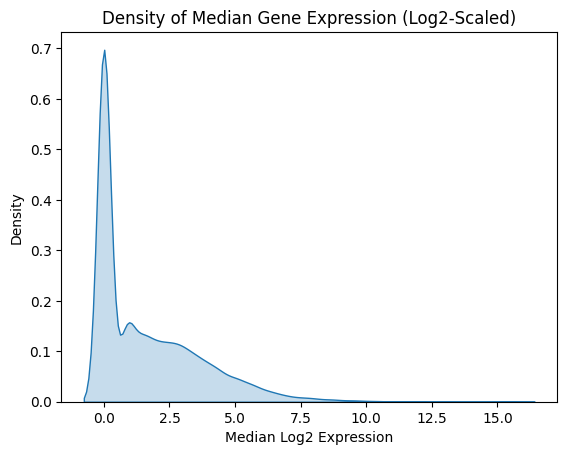

In [4]:
# Plot the density of median gene expression values
sns.kdeplot(median_expression, shade=True)
plt.title("Density of Median Gene Expression (Log2-Scaled)")
plt.xlabel("Median Log2 Expression")
plt.ylabel("Density")
plt.show()

# Part 2

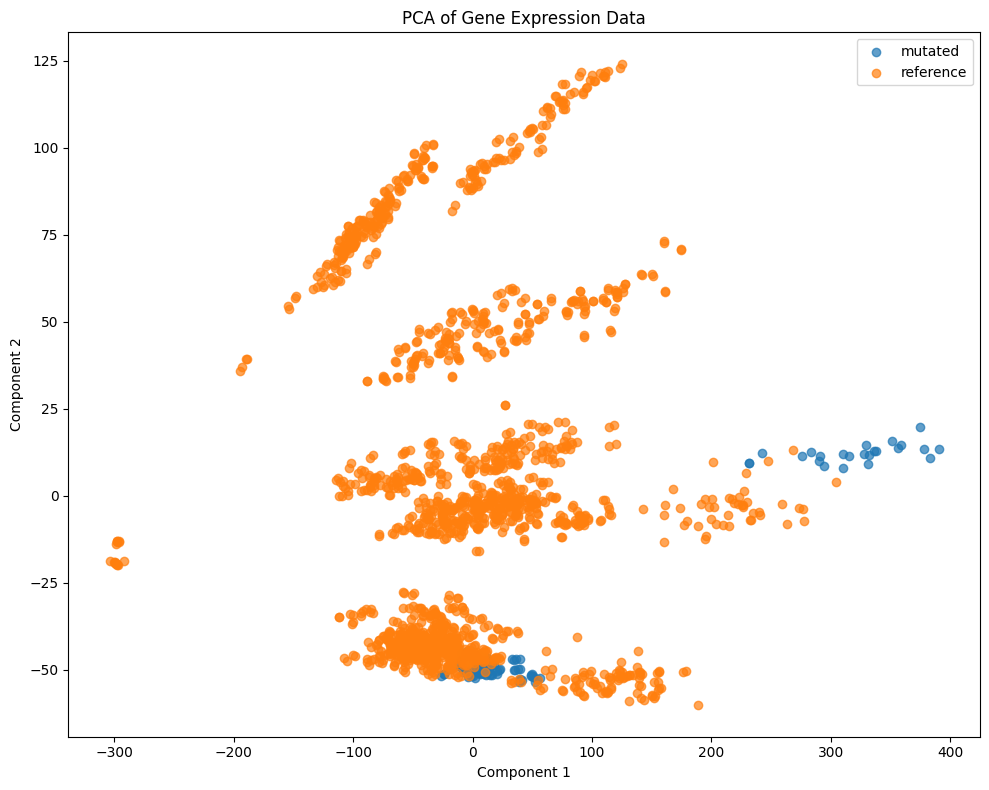

In [5]:
# Part 2 - Sections a - c
# Load the processed data
file_path = 'ERP009868_symbols.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

# Load the metadata
metadata_path = 'metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')

# Create a dictionary to map sample names to their group
sample_to_group = {}
for _, row in metadata.iterrows():
    sample_name = row['refinebio_accession_code']
    if row['refinebio_title'] == "Danio rerio":
        sample_to_group[sample_name] = 'reference'
    else:
        sample_to_group[sample_name] = 'mutated'

# Log-scale the data (adding 1 to avoid log(0))
log_expression_data = np.log2(expression_data + 1)

# Transpose the data so that samples are rows and genes are columns
X = log_expression_data.T

# Create groups list based on the sample order in X
groups = [sample_to_group.get(sample, 'unknown') for sample in X.index]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create plots
def create_plot(X_embedded, title):
    plt.figure(figsize=(10, 8))
    for group in set(groups):
        mask = np.array(groups) == group
        plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=group, alpha=0.7)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
create_plot(X_pca, 'PCA of Gene Expression Data')



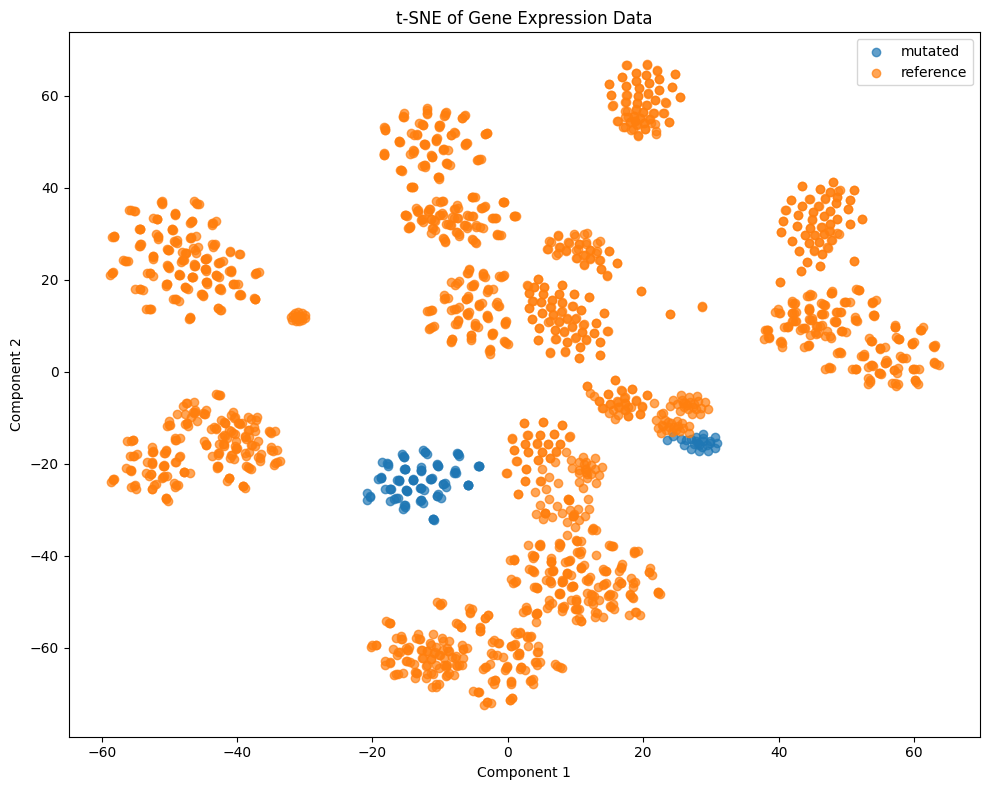

c:\Users\david\OneDrive\Desktop\PythonBioinfoAssingment2\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


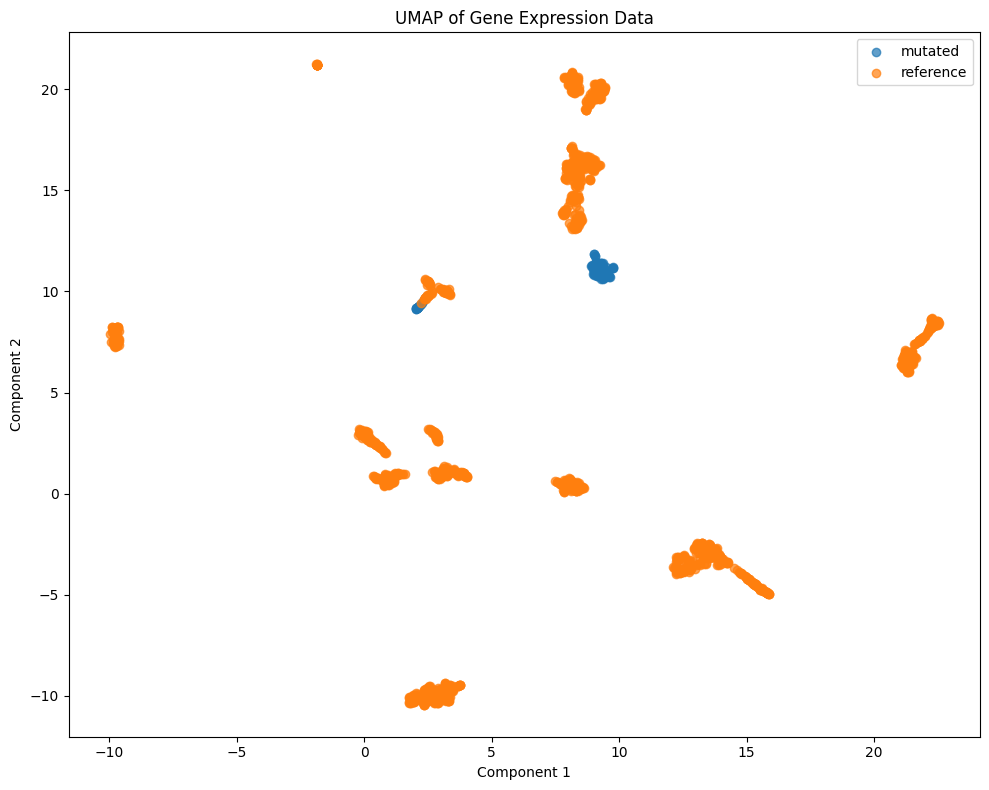

PCA explained variance ratio: [0.23561525 0.07773798]
t-SNE Kullback-Leibler divergence: 0.5035296678543091

Group statistics:
Total samples: 1886
Reference samples: 1766
Mutated samples: 120


In [6]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
create_plot(X_tsne, 't-SNE of Gene Expression Data')

# UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)
create_plot(X_umap, 'UMAP of Gene Expression Data')

# Part 2 - Section e, f
# Print summary statistics for PCA and t-SNE only
print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# t-SNE doesn't have explained variance, but other diagnostics
if hasattr(tsne, 'kl_divergence_'):
    print("t-SNE Kullback-Leibler divergence:", tsne.kl_divergence_)
else:
    print("t-SNE Kullback-Leibler divergence not available.")

# UMAP does not expose similar summary statistics as PCA, so this is skipped
print("\nGroup statistics:")
print(f"Total samples: {len(groups)}")
print(f"Reference samples: {groups.count('reference')}")
print(f"Mutated samples: {groups.count('mutated')}")
if 'unknown' in groups:
    print(f"Unknown samples: {groups.count('unknown')}")


# Part 3

C:\Users\david\AppData\Local\Temp\ipykernel_9028\1636375294.py:23: RuntimeWarning: divide by zero encountered in divide
  log2_fold_change = np.log2(np.mean(mutated_samples, axis=0) / np.mean(reference_samples, axis=0))
C:\Users\david\AppData\Local\Temp\ipykernel_9028\1636375294.py:23: RuntimeWarning: invalid value encountered in divide
  log2_fold_change = np.log2(np.mean(mutated_samples, axis=0) / np.mean(reference_samples, axis=0))
C:\Users\david\AppData\Local\Temp\ipykernel_9028\1636375294.py:23: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(np.mean(mutated_samples, axis=0) / np.mean(reference_samples, axis=0))


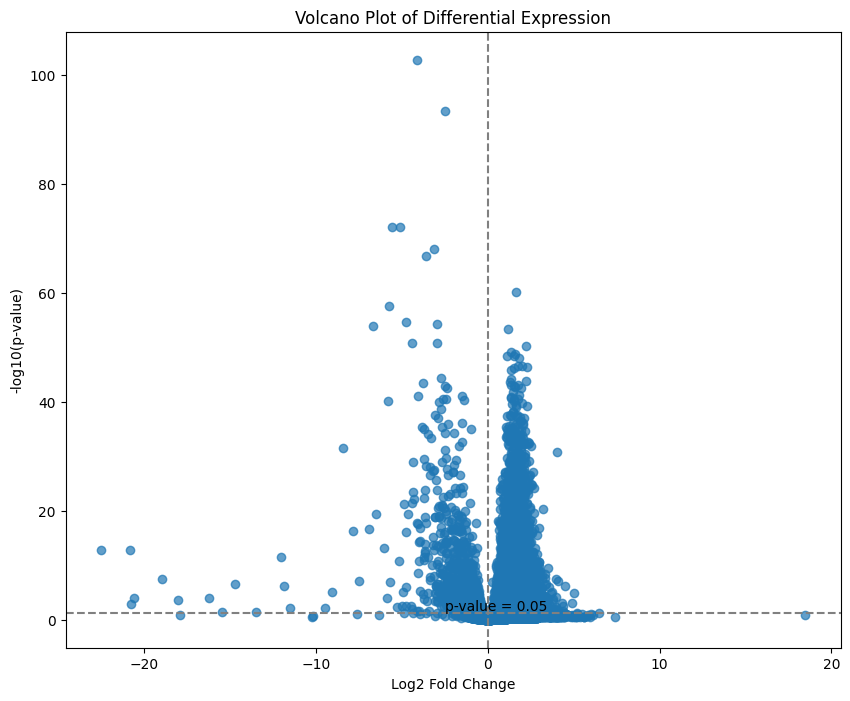

Differential analysis completed. Results saved to files.


In [9]:
# Load the processed data
file_path = 'ERP009868_symbols.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

# Load the metadata
metadata_path = 'metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')

# Create a dictionary to map sample names to their group
sample_to_group = {row['refinebio_accession_code']: row['refinebio_title'] for _, row in metadata.iterrows()}

# Transpose the data so that samples are rows and genes are columns
X = expression_data.T

# Create groups list based on the sample order in X
groups = [sample_to_group.get(sample, 'unknown') for sample in X.index]

# Perform differential analysis
reference_samples = [X.iloc[i] for i, g in enumerate(groups) if g == 'Danio rerio']
mutated_samples = [X.iloc[i] for i, g in enumerate(groups) if g != 'Danio rerio']

t_stats, p_values = ttest_ind(reference_samples, mutated_samples, axis=0, equal_var=False)
log2_fold_change = np.log2(np.mean(mutated_samples, axis=0) / np.mean(reference_samples, axis=0))

# Create a volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(log2_fold_change, -np.log10(p_values), alpha=0.7)
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Differential Expression')
plt.axvline(x=0, color='gray', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--')
plt.text(0.5, -np.log10(0.05) + 0.5, 'p-value = 0.05', ha='center')
plt.savefig('volcano_plot.png')
plt.show()

# Create a table of the top 50 differentially expressed genes
de_genes = pd.DataFrame({
    'Gene': expression_data.index,
    'Log2 Fold Change': log2_fold_change,
    'p-value': p_values
})
de_genes = de_genes.sort_values(by='p-value', ascending=True)
de_genes.to_csv('de_genes.tsv', sep='\t', index=False)
top_50_de_genes = de_genes.head(50)
top_50_de_genes.to_csv('top_50_de_genes.tsv', sep='\t', index=False)

print('Differential analysis completed. Results saved to files.')

# Part 4

<Figure size 1400x1000 with 0 Axes>

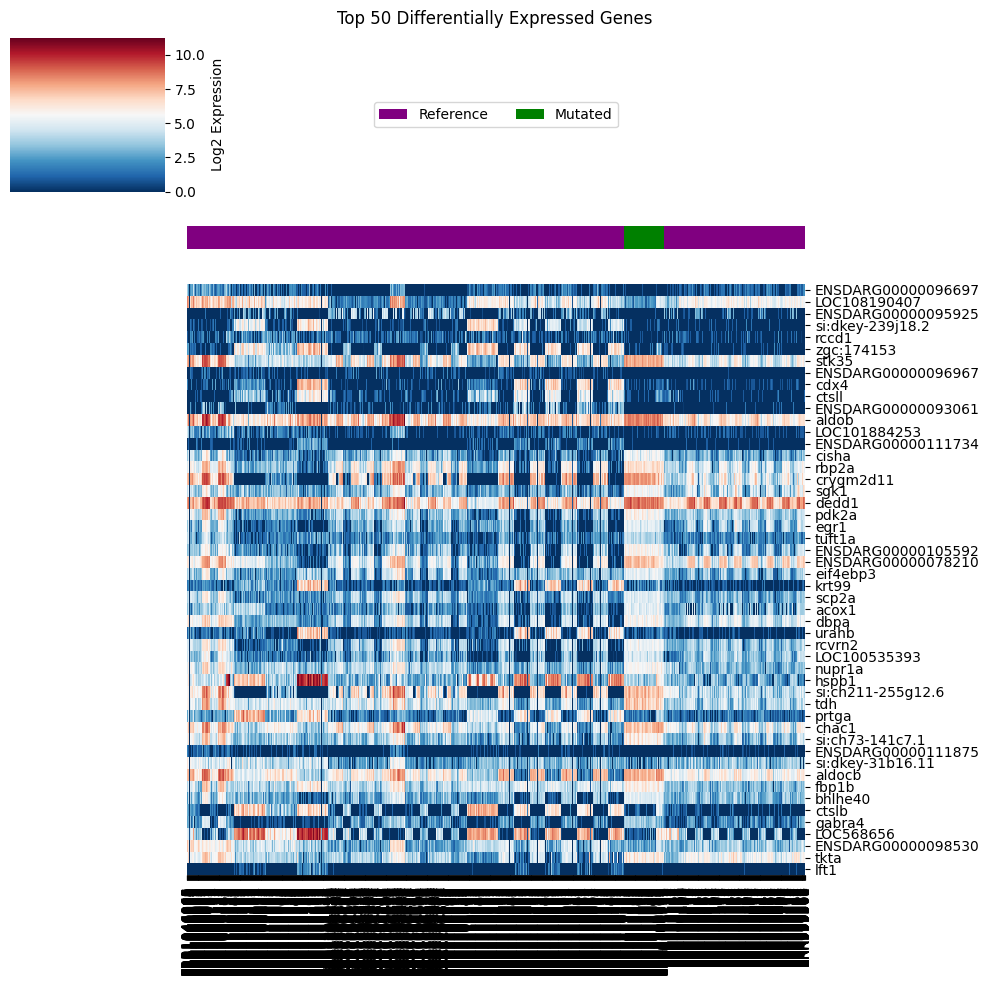

Heatmap of the top 50 differentially expressed genes with side color bar saved to "top_50_de_genes_heatmap_with_sidebar.png".


In [13]:
# Load the top 50 differentially expressed genes
de_genes = pd.read_csv('top_50_de_genes.tsv', sep='\t')

# Load the processed data
file_path = 'ERP009868_symbols.tsv'
expression_data = pd.read_csv(file_path, sep='\t', index_col=0)

# Load the metadata
metadata_path = 'metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t')

# Create a dictionary to map sample names to their group
sample_to_group = {row['refinebio_accession_code']: 'Reference' if row['refinebio_title'] == 'Danio rerio' else 'Mutated' 
                   for _, row in metadata.iterrows()}

# Create a heatmap of the top 50 differentially expressed genes
log2_expression = np.log2(expression_data.loc[de_genes['Gene']] + 1)

# Create a color mapping
color_map = {'Reference': 'purple', 'Mutated': 'green'}

# Create a color list for the columns
col_colors = [color_map[sample_to_group[sample]] for sample in log2_expression.columns]

# Create the main figure
plt.figure(figsize=(14, 10))

# Plot the heatmap with a side color bar
g = sns.clustermap(log2_expression, 
                   cmap='RdBu_r',
                   col_colors=col_colors,
                   col_cluster=False,
                   row_cluster=False,
                   cbar_kws={'label': 'Log2 Expression'},
                   yticklabels=True,
                   xticklabels=True)

# Rotate x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

# Add a legend
for label in color_map:
    g.ax_col_dendrogram.bar(0, 0, color=color_map[label], label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=2)

# Set the title
g.fig.suptitle('Top 50 Differentially Expressed Genes')

# Adjust the layout and save the figure
plt.tight_layout()
plt.savefig('top_50_de_genes_heatmap_with_sidebar.png', bbox_inches='tight')
plt.show()

print('Heatmap of the top 50 differentially expressed genes with side color bar saved to "top_50_de_genes_heatmap_with_sidebar.png".')

# Part 5

In [3]:
# Load the metadata
de_genes_path = 'de_genes.tsv'
de_genes = pd.read_csv(de_genes_path, sep='\t')
print(de_genes)
# Filter for significant genes
sig_genes = de_genes[de_genes['p-value'] < 0.05]
gene_list = sig_genes.set_index('Gene')['Log2 Fold Change'].to_dict()

# Initialize gProfiler
gp = GProfiler(user_agent="my_gprofiler_app/1.0")

# Run the enrichment analysis
results = gp.profile(
    query=list(gene_list.keys()),
    organism='drerio',  # Change to your organism (e.g., 'mmusculus' for mouse),
    sources = ['GO'],
    all_results=True
)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to CSV
results_df.to_csv('DaveyCollins_GO_enrichment_results.csv', index=False)

print("gProfiler analysis complete. Results saved to 'DaveyCollins_GO_enrichment_results.csv'.")

                     Gene  Log2 Fold Change        p-value
0      ENSDARG00000096697         -4.139247  1.556279e-103
1            LOC108190407         -2.512424   4.157485e-94
2      ENSDARG00000095925         -5.609329   6.634221e-73
3        si:dkey-239j18.2         -5.112487   8.939452e-73
4                   rccd1         -3.115851   9.221008e-69
...                   ...               ...            ...
29341     si:dkey-83f18.3               NaN            NaN
29342     si:dkey-83f18.7               NaN            NaN
29343             taar12m               NaN            NaN
29344               tssk6               NaN            NaN
29345               ucn3l               NaN            NaN

[29346 rows x 3 columns]
gProfiler analysis complete. Results saved to 'DaveyCollins_GO_enrichment_results.csv'.


# Part 6

In [5]:
import pandas as pd

# Load your KEGG, GO, Reactome, and TransFac enrichment results
kegg_results_path = 'Robertmann_KEGG_enrichment_results.csv'  # Path to your KEGG results
go_results_path = 'DaveyCollins_GO_enrichment_results.csv'  # Path to your GO results
reactome_results_path = 'AdamKing_REACTOME_results.csv'  # Path to your Reactome results
transfac_results_path = 'DimitriDimitrakisgProfiler2_enrichment.csv'  # Path to your TransFac results

kegg_df = pd.read_csv(kegg_results_path)
go_df = pd.read_csv(go_results_path)
reactome_df = pd.read_csv(reactome_results_path)
transfac_df = pd.read_csv(transfac_results_path)

# Check the columns of each DataFrame
print("KEGG DataFrame columns:", kegg_df.columns.tolist())
print("GO DataFrame columns:", go_df.columns.tolist())
print("Reactome DataFrame columns:", reactome_df.columns.tolist())
print("TransFac DataFrame columns:", transfac_df.columns.tolist())

# Define the columns you care about for all analyses
columns_of_interest = [
    'description', 'p_value', 'native', 'precision', 'recall',
    'query_size', 'term_size', 'significant', 'source'
]

# Filter KEGG results for statistically significant terms (p-value < 0.05, adjust as needed)
significant_kegg_df = kegg_df[kegg_df['p_value'] < 0.05][columns_of_interest]

# Filter GO results for statistically significant terms (p-value < 0.05, adjust as needed)
significant_go_df = go_df[go_df['p_value'] < 0.05][columns_of_interest]

# Filter Reactome results for statistically significant terms (p-value < 0.05, adjust as needed)
significant_reactome_df = reactome_df[reactome_df['p_value'] < 0.05][columns_of_interest]

# Filter TransFac results for statistically significant terms (p-value < 0.05, adjust as needed)
significant_transfac_df = transfac_df[transfac_df['p_value'] < 0.05][columns_of_interest]

# Merge the results on 'description' to match terms across methods
merged_df = pd.merge(significant_kegg_df, significant_go_df, on='description', how='outer', suffixes=('_kegg', '_go'))
merged_df = pd.merge(merged_df, significant_reactome_df, on='description', how='outer', suffixes=('', '_reactome'))
merged_df = pd.merge(merged_df, significant_transfac_df, on='description', how='outer', suffixes=('', '_transfac'))

# Check merged DataFrame columns to debug
print("Merged DataFrame columns after TransFac merge:", merged_df.columns.tolist())

# Combine the columns for KEGG, GO, Reactome, and TransFac into a single column for each attribute
merged_df['p_value'] = merged_df[['p_value_kegg', 'p_value_go', 'p_value', 'p_value_transfac']].min(axis=1)
merged_df['precision'] = merged_df[['precision_kegg', 'precision_go', 'precision', 'precision_transfac']].max(axis=1)
merged_df['recall'] = merged_df[['recall_kegg', 'recall_go', 'recall', 'recall_transfac']].max(axis=1)
merged_df['query_size'] = merged_df[['query_size_kegg', 'query_size_go', 'query_size', 'query_size_transfac']].max(axis=1)
merged_df['term_size'] = merged_df[['term_size_kegg', 'term_size_go', 'term_size', 'term_size_transfac']].max(axis=1)
merged_df['significant'] = merged_df[['significant_kegg', 'significant_go', 'significant', 'significant_transfac']].max(axis=1)

# For 'native' and 'source', if any method has a value, retain it
merged_df['native'] = merged_df[['native_kegg', 'native_go', 'native', 'native_transfac']].apply(lambda row: ' | '.join(row.dropna()), axis=1)
merged_df['source'] = merged_df[['source_kegg', 'source_go', 'source', 'source_transfac']].apply(lambda row: ' | '.join(row.dropna()), axis=1)

# Add columns to count methods that found each term and methods that included each term
merged_df['methods_found'] = merged_df[['p_value_kegg', 'p_value_go', 'p_value', 'p_value_transfac']].apply(lambda row: sum(row < 0.05), axis=1)
merged_df['methods_included'] = 4  # Since KEGG, GO, Reactome, and TransFac are included

# Drop the original suffix columns (kegg, go, reactome, transfac)
merged_df.drop(columns=[
    'p_value_kegg', 'p_value_go', 'p_value_transfac',
    'precision_kegg', 'precision_go', 'precision_transfac',
    'recall_kegg', 'recall_go', 'recall_transfac',
    'query_size_kegg', 'query_size_go', 'query_size_transfac',
    'term_size_kegg', 'term_size_go', 'term_size_transfac',
    'significant_kegg', 'significant_go', 'significant_transfac',
    'native_kegg', 'native_go', 'native_transfac',
    'source_kegg', 'source_go', 'source_transfac'
], inplace=True)

# Save the merged results table
output_path = 'significant_enriched_terms_combined.csv'
merged_df.to_csv(output_path, index=False)

print(f"Table of significantly enriched terms (KEGG, GO, Reactome, and TransFac) saved to {output_path}")

KEGG DataFrame columns: ['description', 'effective_domain_size', 'intersection_size', 'name', 'native', 'p_value', 'parents', 'precision', 'query', 'query_size', 'recall', 'significant', 'source', 'term_size']
GO DataFrame columns: ['description', 'effective_domain_size', 'intersection_size', 'name', 'native', 'p_value', 'parents', 'precision', 'query', 'query_size', 'recall', 'significant', 'source', 'term_size']
Reactome DataFrame columns: ['description', 'effective_domain_size', 'intersection_size', 'name', 'native', 'p_value', 'parents', 'precision', 'query', 'query_size', 'recall', 'significant', 'source', 'term_size']
TransFac DataFrame columns: ['description', 'effective_domain_size', 'intersection_size', 'name', 'native', 'p_value', 'parents', 'precision', 'query', 'query_size', 'recall', 'significant', 'source', 'term_size']
Merged DataFrame columns after TransFac merge: ['description', 'p_value_kegg', 'native_kegg', 'precision_kegg', 'recall_kegg', 'query_size_kegg', 'term_si

# Part 7

In [6]:
# Filter for terms found in at least 2 methods (you can adjust this number as needed)
filtered_terms = merged_df[merged_df['methods_found'] >= 2]

# Sort by p_value to find the most significant terms
top_terms = filtered_terms.sort_values(by='p_value').head(10)

# Select relevant columns for the final output
combined_top_terms = top_terms[['description', 'p_value', 'methods_found', 'native', 'source']]

# Save the combined top terms to a CSV
output_top_terms_path = 'top_enriched_terms_combined.csv'
combined_top_terms.to_csv(output_top_terms_path, index=False)

print(f"Top enriched terms saved to {output_top_terms_path}")

Top enriched terms saved to top_enriched_terms_combined.csv
